# Single Polymorphic Simulation Run Trace

(c) 2020 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In [1]:
using LinearAlgebra, Jevo, Jedi, Plots, LambertW, Statistics, Distributions
Jedi.default_gr!()

# Parameters
N = 100
ϵ = 2
n = 4
emat = ϵ * (ones(4, 4) - Matrix{Float64}(I, 4, 4))
f0 = 100/2N

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-467731639463163702\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11904601742115298477\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-467731639463163702\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

0.5

In [2]:
F = Jevo.fermi_fitness(f0=f0, fl=0, epsilon=ϵ);
# Length scale
l0(n, F) = 1/F.epsilon * lambertw(2 * F.epsilon^2 * N * 10 * F.f0 * (n-1)/n^2* exp(5 * F.epsilon))
l0(κ, l, n, F) = 1/F.epsilon * lambertw(2 * F.epsilon^2 * N * l * F.f0 * (n-1)/n^2 * exp(5 * F.epsilon)/(1 + κ))

# Find length cost to set length in equilibrium (derived from genetic load modified by length dynamics)
lambda_new(l_opt, n, F) = l0(n, F)^3 / l_opt^2 * n^2 / (n-1) * 1/2
lambda_new(l_opt, κ, l, n, F) = l0(κ, l, n, F)^3 / l_opt^2 * n^2 / (n-1) * 1/2

#l_opt_static(κ, ϵ, n) = l0(ϵ, n) * sqrt(n^2 / ((n - 1) * ϵ * lambda(10)) * (1+κ))
l_opt_dynamic(κ, n, F) = l0(n, F)^(3/2) * sqrt(n^2 / ((n - 1) * 2 * lambda_new(10, n, F)) * (1+κ))
F = Jevo.fermi_fitness(f0=f0, fl=lambda_new(10, n, F)/(2N*l0(n, F)), epsilon=ϵ)

Jevo.fermi_fitness(10, 1.0, 2.0, 0.5, 0.006516807214942228, Jevo.Est)

In [3]:
function Q(k::Int, l::Int, F::Jevo.fitness_functions, n::Int, κ::Real, N::Int)
    # Neutral diversity
    delta_0 = 1/ n * 0.1 *l
    q0 = binomial(BigInt(l), BigInt(k))  * ((n-1)/n)^k * (1/n)^(l-k)
    q = q0 * exp( (2N / (1+κ)) * Jevo.fitness(k * F.epsilon, l, F))
    return q
end

Q (generic function with 1 method)

In [4]:
function pick_k(l::Int, F::Jevo.fitness_functions, n::Int, κ::Real, N::Int)
    Q_k = [Q(k, l, F, n, κ, N) for k in 0:1:l]
    Q_k /= sum(Q_k)
    k = findfirst(cumsum(Q_k) .>= rand()) 
    #println("k: ", k)
    return k - 1
end

pick_k (generic function with 1 method)

In [5]:
function selection_coefficients(k::Int, l::Int, F::Jevo.fitness_functions)
    s_plus_match = Jevo.fitness(k, l + 1, F) - Jevo.fitness(k, l, F)
    s_plus_mismatch = Jevo.fitness(k + F.epsilon, l + 1, F) - Jevo.fitness(k, l, F)

    s_minus_match = Jevo.fitness(k, l, F) .- Jevo.fitness(k, l + 1, F)
    s_minus_mismatch = Jevo.fitness(k - F.epsilon, l, F) - Jevo.fitness(k, l + 1, F)
    return s_plus_match, s_plus_mismatch, s_minus_match, s_minus_mismatch
end

selection_coefficients (generic function with 1 method)

In [8]:
function trajectory(l0::Int, n::Int, F::Jevo.fitness_functions, N::Int, κ::Real, steps::Int)
    l_arr = zeros(Int, steps+1)
    l_arr[1] = l0
    k_arr = zeros(Int, steps)
    for i in 1:steps
        k = pick_k(l_arr[i], F, n, κ, N)
        k_arr[i] = k
        s_plus_match, s_plus_mismatch, s_minus_match, s_minus_mismatch = selection_coefficients(k, l_arr[i], F)
        m_s_p = 1/n * s_plus_match + (n-1)/ n * s_plus_mismatch
        m_s_m = (1-k/l_arr[i]) * s_minus_match + k/l_arr[i] * s_minus_mismatch
        up = Jevo.kimura_prob(m_s_p, N)
        down = Jevo.kimura_prob(m_s_m, N)
        rand_var = rand(Bernoulli(up /(up + down)))[1]
        
        
        
        if rand_var
            l_arr[i+1] = l_arr[i] + 1
        elseif l_arr[i] > 1 
            l_arr[i+1] = l_arr[i] - 1
        else
            l_arr[i+1] = l_arr[i]
        end
    end
    return l_arr, k_arr
end

trajectory (generic function with 1 method)

In [7]:
F = Jevo.fermi_fitness(f0=f0, fl=lambda_new(10, n, F)/(2N*l0(n, F)), epsilon=ϵ)
y1 = trajectory(15, n, F, N, 0, 10^4)
y2 = trajectory(15, n, F, N, 3, 10^4);

LoadError: UndefVarError: l not defined

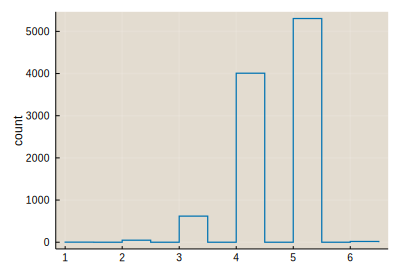

In [156]:
Jedi.histogram(data=y2)

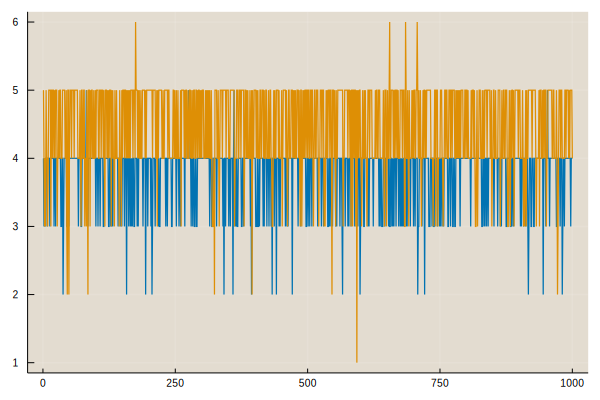

In [157]:
plot([y1[1:10:end] y2[1:10:end]])

In [158]:
mean(y1)

3.7552

In [159]:
mean(y2)

4.462

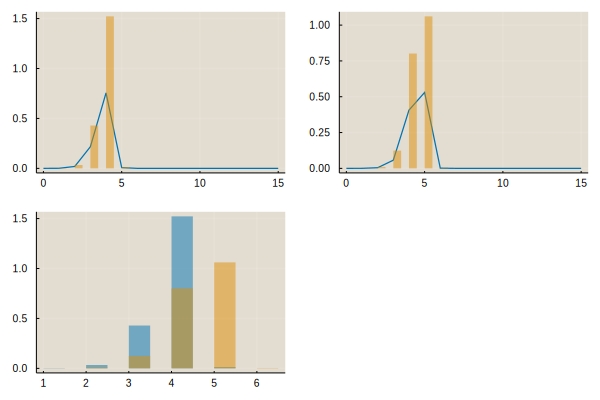

In [160]:
l = 15
p1 = [Q(x, l, F, n, 0, N) for x in 0:1:l]
p1 /= sum(p1)

p2 = [Q(x, l, F, n, 3, N) for x in 0:1:l]
p2 /= sum(p2)

plot_1 = plot(0:1:l, p1)
Jedi.histogram(p=plot_1, data=y1, density=true, kind="step_filled",patch_kwargs=Dict(:alpha=>0.5))
plot_2 = plot(0:1:l, p2)
Jedi.histogram(p=plot_2, data=y2, density=true, kind="step_filled",patch_kwargs=Dict(:alpha=>0.5))
plot_3 = plot()
Jedi.histogram(p=plot_3, data=y1, density=true, kind="step_filled",patch_kwargs=Dict(:alpha=>0.5))
Jedi.histogram(p=plot_3, data=y2, density=true, kind="step_filled",patch_kwargs=Dict(:alpha=>0.5))
plot([plot_1, plot_2, plot_3]...)

In [145]:
mean(y1)

3.7423

In [111]:
?Jedi.histogram

```
histogram(data=None, bins=10, p=nothing, density=false, kind="step", line_kwargs=Dict(), patch_kwargs=Dict();
    kwargs...
)
```

Make a plot of a histogram of a data set.

# Parameters

---

  * `data` : 1D array of data to make a histogram out of
  * `bins` : int, array-like, or one of `"exact"` or `"integer"` default `10`. Setting for `bins` kwarg to be passed to `fit(Histogram, data, nbins=bins)`. If `"exact"`, then each unique value in the data gets its own bin. If `"integer"`, then integer data is assumed and each integer gets its own bin.
  * `p` : `Plots.plot`, or `nothing` (default). If `nothing`, create a new figure. Otherwise, populate the existing figure `p`.
  * `density` : Bool, default false. If `true`, normalized the histogram. Otherwise, base the histogram on counts.
  * `kind` : string, default `"step"`. The kind of histogram to display. Allowed values are `"step"` and `"step_filled"`.
  * `line_kwargs` : Dict. Any kwargs to be passed to `Plots.plot()` in making the line of the histogram.
  * `patch_kwargs` : Dict. Any kwargs to be passed to `fill_between()` in making the fill of the histogram.
  * `kwargs` : Dict. All other kwargs are passed to `Plots.plot()`

# Returns

---

  * `p` : Plots figure. Figure populated with histogram.
